In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers.legacy import RMSprop,Adam
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import re
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense,LeakyReLU,BatchNormalization,Input,Conv2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
import torch
import gc

In [3]:
def alphanumeric(data):
    #Defining a transform function which transforms a text elements to an integer if digits are present else it lower case the text
    def transform(text):
        return int(text) if text.isdigit() else text.lower()
    def alphanum_key(key):
        return [transform(i) for i in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
size = 128
image = []
path = '/content/drive/MyDrive/part1'
images = os.listdir(path)
images = alphanumeric(images)
for i in tqdm(images):
    if i == 'seed10000.png':
        break
    else:
            img = cv2.imread(path + '/'+i,1)
            #  convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (size, size))
            img = (img - 127.5) / 127.5
            img = img.astype(float)
            image.append(img_to_array(img))

100%|██████████| 10155/10155 [05:53<00:00, 28.73it/s]


In [5]:
def build_discriminator():
    model = Sequential()
    model.add(Input((size, size, 3)))
    #Stride more than 1: Decreases the spatial dimensions of the output feature maps
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1,activation = 'sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [6]:
latent_dim = 100
def build_generator():
    model = Sequential()
    #fully connected layer with (128*128*3) units, input shape is set to latent dim
    #The use_bias=False parameter indicates that the layer does not use bias terms.
    #128 - width, 128 - height and 3 number of channels
    model.add(Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    #The output of the fully connected layer is reshaped into a 4D tensor with dimensions (128, 128, 3)
    model.add(Reshape((128,128,3)))
    model.add(Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    #tanh activation function is used, which squashes the output values between -1 and 1.
    model.add(Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))



    return model

In [7]:
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     6144      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_5 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

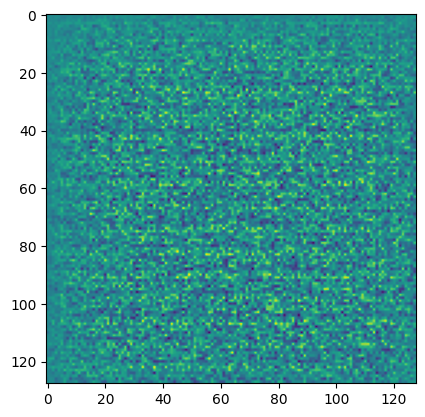

In [8]:
noise = np.random.normal(-1,1,(1,100))
#(1, 100), meaning it's a 1D array with 100 elements.
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [9]:
optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
      )


cross_entropy = BinaryCrossentropy(from_logits = False)

In [10]:
def g_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image),fake_image)
def d_loss(fake_image, real_image):
    fake_loss = cross_entropy(tf.zeros_like(fake_image),fake_image)
    real_loss = cross_entropy(tf.ones_like(real_image),real_image)
    return fake_loss + real_loss

<ipython-input-11-9778160577cd>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


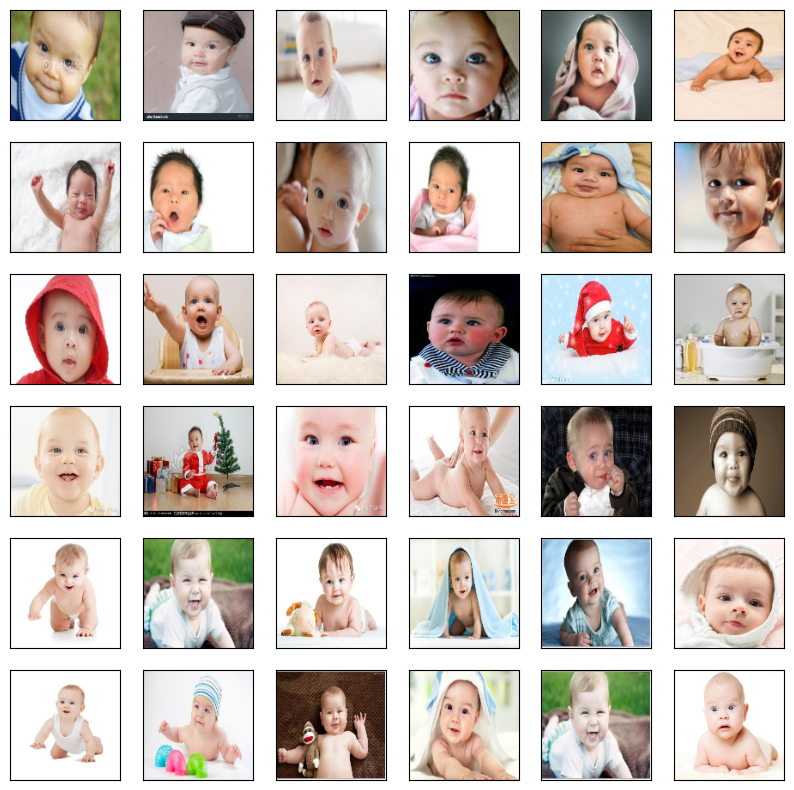

In [11]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(image[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

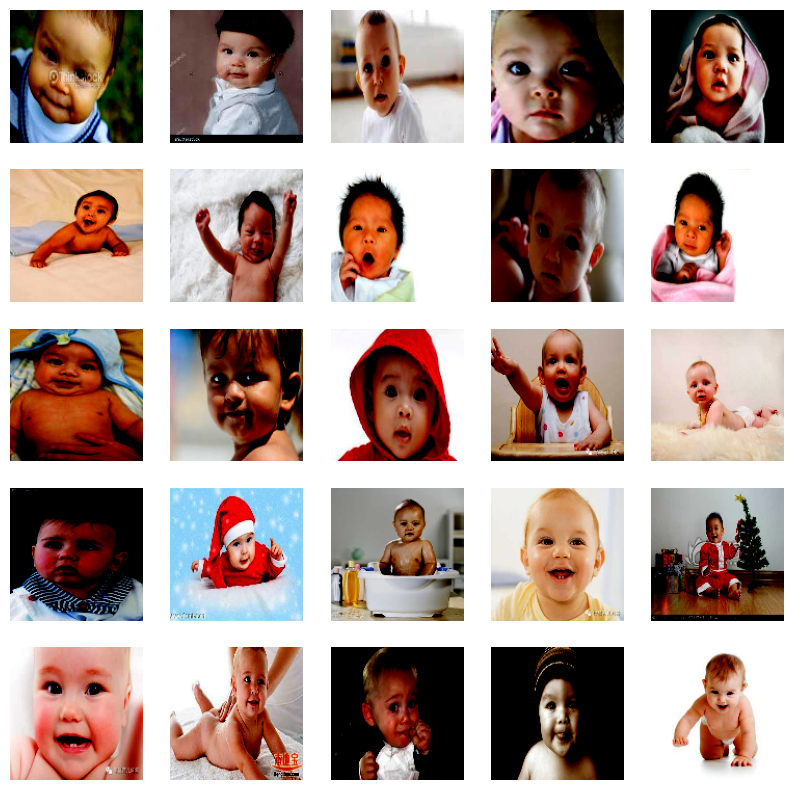

In [12]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(image[5*i + j])
        ax[i, j].axis('off')

plt.show()

In [13]:
data = np.array(image)
print(data.shape)

(10155, 128, 128, 3)


In [14]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(image)).batch(batch_size)

In [15]:
data  = np.array(dataset)
print(data.shape)

()


In [16]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_image = discriminator(generated_images)
        real_image = discriminator(images)

        gen_loss = g_loss(fake_image)
        dis_loss = d_loss(fake_image, real_image)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [17]:
def image_generator(square = 5, epochs = 0):
    plt.figure(figsize = (10,10))
    plt.suptitle("Non existing faces created", fontsize=20, color='black')
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

In [18]:
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch running/completed : {}".format(epoch + 1))
        for images in tqdm(dataset):
            loss = train_steps(images)
        print(" Time taken:{}".format(np.round(time.time() - start),2))
        print("Generator Loss is: {} Discriminator Loss is: {}".format(loss['gen loss'],loss['disc loss']))

In [19]:
gc.collect()

15

In [20]:
train(5,dataset)


Epoch running/completed : 1


100%|██████████| 318/318 [11:23<00:00,  2.15s/it]


 Time taken:684.0
Generator Loss is: 5.41126823425293 Discriminator Loss is: 0.7951353192329407

Epoch running/completed : 2


100%|██████████| 318/318 [10:21<00:00,  1.96s/it]


 Time taken:622.0
Generator Loss is: 0.0017124457517638803 Discriminator Loss is: 6.370688438415527

Epoch running/completed : 3


100%|██████████| 318/318 [09:50<00:00,  1.86s/it]


 Time taken:590.0
Generator Loss is: 9.418876647949219 Discriminator Loss is: 0.006828273180872202

Epoch running/completed : 4


100%|██████████| 318/318 [09:39<00:00,  1.82s/it]


 Time taken:579.0
Generator Loss is: 31.127586364746094 Discriminator Loss is: 3.6156017069188806e-10

Epoch running/completed : 5


100%|██████████| 318/318 [09:21<00:00,  1.77s/it]

 Time taken:562.0
Generator Loss is: 23.931673049926758 Discriminator Loss is: 0.01528009120374918


In [24]:
gc.collect()

49182

In [25]:
train(1,dataset)


Epoch running/completed : 1


100%|██████████| 318/318 [09:02<00:00,  1.70s/it]


 Time taken:542.0
Generator Loss is: 18.42431640625 Discriminator Loss is: 6.181176286190748e-05


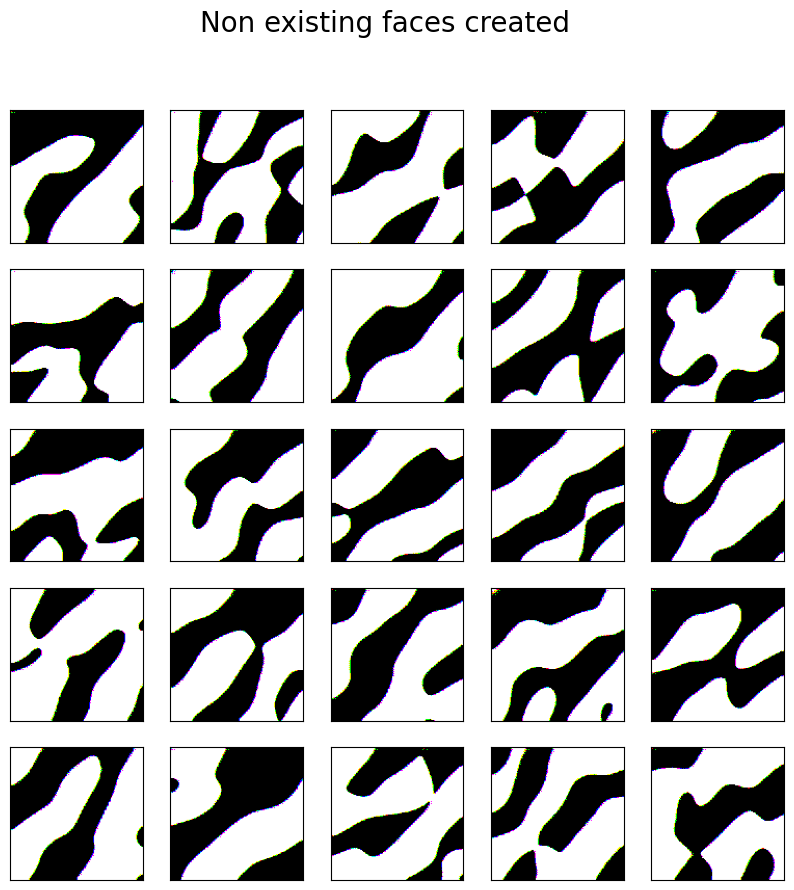

In [26]:
image_generator(5)